# 1.State the region and the domain category that your data sets are about (e.g., Chaohu, China and sports or athletics).

- Region: South Korea
- Domain Category: E-Sports


# 2. Create a research question about the domain category and region that you identified.

A player can pick among three different factions in Starcraft 2: Zerg, Protoss, and Terran. Generally, game developers are likely to keep the game balanced so that each faction is about equally powerful.This means we should see very similar win-rates between factions.

Below, I will examine the win rates for three different factions acorss three addons. An addon represents a significant patch in the game that lead to balances changes between factions. The goal will be to examine if there are any races within each of those addons that are significantly stronger.

# 3. Datasets
We will be loading the following datasets:

* Starcraft 2 matches dataset. Information about the dataset can be found [here](https://www.kaggle.com/alimbekovkz/starcraft-ii-matches-history/data). This data contains over 200k records of Starcraft 2 matches.
* Starcraft 2 player countries. This data was scraped from the following wiki: http://wiki.teamliquid.net/starcraft2/Players_(All). This data contains the player names and the player countries. 

In [1]:
# player countries data
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import datetime as dt

url = "http://wiki.teamliquid.net/starcraft2/Players_(All)"
response = requests.get(url)
dfs =pd.read_html(response.content)

# concatenate player tables together
players = pd.concat(dfs[1:])
players.columns = ['player_name', 'name', 'team', 'country', 'race', 'stream']
players = players[players['player_name'] != 'ID'] # remove id columns
players = players[~pd.isnull(players['country'])] # remove empty placeholders
players.drop(['name', 'team', 'race', 'stream'], axis = 1, inplace=True)
players.head()

,player_name,country
1,HateMe,Austria
2,Cube,Austria
3,monchi,Austria
2,LoWeLy,Belarus
2,Feast,Belgium


In [2]:
player_matches = pd.read_csv('sc2-matches-history.csv')
player_matches.reset_index(inplace=True)
player_matches.rename(columns={'index':'match_id'}, inplace=True)
player1_info = player_matches[['match_id','match_date','player_1', "player_1_match_status",
                               'score', 'player_1_race', 'addon', 'tournament_type']].copy()
player1_info.columns = ['match_id','match_date','player_name', "player_match_status",
                               'score', 'player_race', 'addon', 'tournament_type']
player1_info['player'] = 'player1'

player2_info = player_matches[['match_id','match_date','player_2', "player_2_match_status",
                               'score', 'player_2_race', 'addon', 'tournament_type']].copy()
player2_info.columns = ['match_id','match_date','player_name', "player_match_status",
                               'score', 'player_race', 'addon', 'tournament_type'].copy()
player2_info['player'] = 'player2'
player_matches = player1_info.append(player2_info)
player_matches.drop(['match_id', 'match_date', 'score', 'tournament_type', 'player'], axis = 1,
                   inplace=True)
player_matches.head()

,player_name,player_match_status,player_race,addon
0,MC,[loser],P,LotV
1,MC,[winner],P,LotV
2,MC,[loser],P,LotV
3,MC,[loser],P,LotV
4,MC,[loser],P,LotV


In [3]:
df = player_matches.merge(players, how='left', on='player_name')
# filter matches with country of South Korea
df = df[df['country']=='South Korea']
df = df[df['player_race'] != 'R']
df['player_match_status'] = np.where(df.player_match_status == '[winner]', 1, 0)


df.loc[df['player_race'] == 'P', 'player_race'] = 'Protoss'
df.loc[df['player_race'] == 'Z', 'player_race'] = 'Zerg'
df.loc[df['player_race'] == 'T', 'player_race'] = 'Terran'

df.player_race.value_counts()

Terran     68318
Zerg       59886
Protoss    59072
Name: player_race, dtype: int64

In [4]:
cleaned_df = df.groupby(['player_race', 'addon']).agg({'player_match_status': [np.mean, len, np.std]})
cleaned_df

player_match_status                 
                                 mean    len       std
player_race addon                                     
Protoss     HotS             0.596453  26951  0.490618
            LotV             0.549931  12307  0.497521
            WoL              0.567831  19814  0.495390
Terran      HotS             0.593397  26714  0.491209
            LotV             0.622941  16756  0.484664
            WoL              0.574332  24848  0.494454
Zerg        HotS             0.591460  26837  0.491573
            LotV             0.615662  12476  0.486458
            WoL              0.568415  20573  0.495309

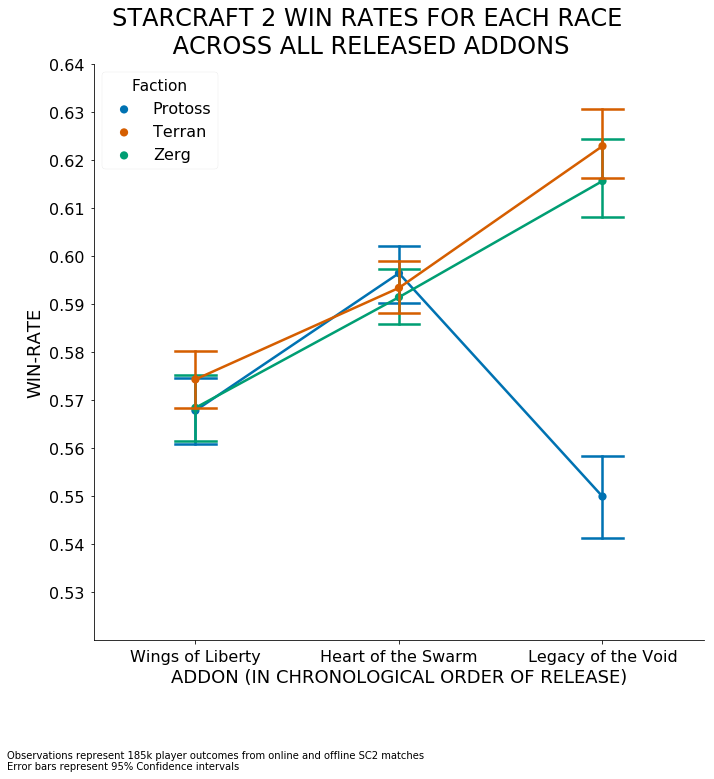

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper", rc={"font.size":18,
                             "axes.titlesize":18,
                             "axes.labelsize":18,
                             "xtick.labelsize": 16,
                             "ytick.labelsize": 16,
                             'legend.fontsize': 16
                            })   
sns.set_palette('colorblind')
ax = sns.factorplot(x="addon",
               y="player_match_status",
               hue="player_race",
               data=df,
               capsize=.2,
               legend_out=False,
               size=10,
               aspect=1,
               order=['WoL', 'HotS', 'LotV'], ci=95)
ax.fig.suptitle('Starcraft 2 win rates for each race\n across all released addons'.upper(),
               fontsize=24)
ax.set(ylabel='Win-rate'.upper(),
       xlabel="Addon (in chronological order of release)".upper(),
       yticks=np.arange(0.53,0.65,0.01),
       ylim = (0.52, 0.64))
ax.fig.subplots_adjust(top=.9, bottom=0.1)
ax.set_xticklabels(['Wings of Liberty', 'Heart of the Swarm', 'Legacy of the Void'])
ax.add_legend(title='Faction')

ax.fig.text(0.0, -0.08,
     'Observations represent 185k player outcomes from online and offline SC2 matches\n'
     'Error bars represent 95% Confidence intervals',
      fontsize=10)

plt.show()

**Figure Explanation**:
The figure above shows the win rates for each race and addon in Starcraft 2. We can clearly see that the first two addons had little to no balance differences between races--the win rates for all races are fairly similar. We can also see that the last addon shows a significant dip in win-rate for the protoss race. Normally, this type of discrepancy would be quickly corrected by game developers. Nontheless, the Starcraft 2 game is fairly old and decreasing in popularity (e.g., Legacy of the Void was released 5 years after Wings of Liberty). The lack of popularity likely led to less developed time being spent on patching any imbalance between races.    

## For each of the following prompts, please provide a response that links each principle to one or more elements of your visual.

- Truthfulness: This visualization conforms to this principle because the filtering, aggregation, and transformations that I applied to the data do not mislead the audience about the underlying patterns. Moreover, although I did not scale the y-axis from 0, I made sure to point out that the patterns in the data are real by putting them in the context of confidence intervals. 
- Functional: I removed most of the chart junk that did not have to do with providing useful infromation to the reader (e.g., removed the grid lines).
- Beautiful: The fonts, ticks, and labels were rescaled to make it easier for the reader to process the figure. I also selected a colorblind palette.
- Insightfulness: This observation is insightful because it shows a clear discrepancy and balance issues that are present in the game. This is relevant information to both players and game developers. 